Populating the interactive namespace from numpy and matplotlib


C:\Users\ronnie\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\Users\ronnie\Anaconda3\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in sign


20.4218463663


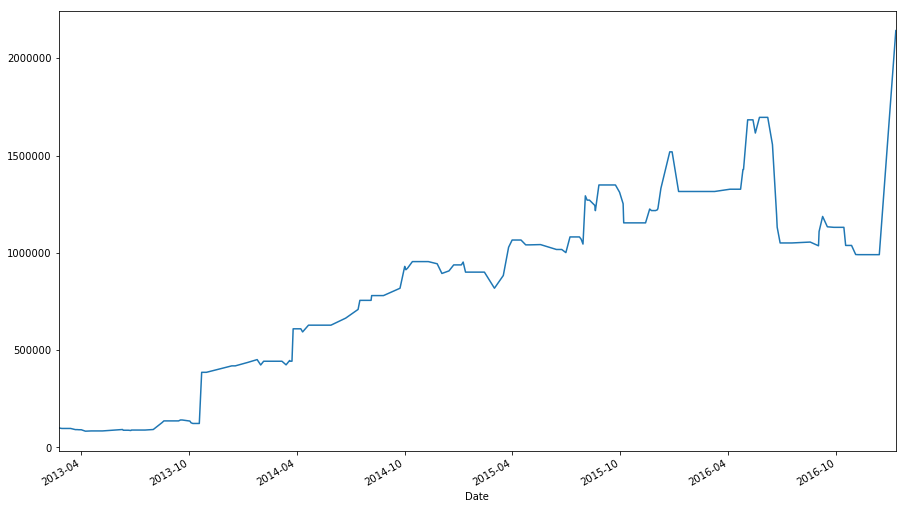

In [6]:
import pandas as pd
import pandas_datareader.data as web
#import pandas.io.data as web # Package and modules for importing data; this code may change depending on pandas version
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import pylab
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
import numpy as np

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

def adjdata(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices

    :return: pandas DataFrame with adjusted stock data

    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                         "Close": dat["Adj Close"]})
                       #")





def rsicrossover_orders(stocks,fast,slow):

    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
    
    trades = pd.DataFrame({"Price": [], "Signal": []})
    for s in stocks:
        
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = s[1]["Close"].rolling(window = fast, center = False).mean()
        s[1][slow_str] = s[1]["Close"].rolling(window = slow, center = False).mean() 
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]



        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)

        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])

        regime_orig = s[1].ix[-1, "Regime"]
        s[1].ix[-1, "Regime"] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        s[1].ix[-1, "Regime"] = regime_orig   
    
       # s[1]["rsi"]=rsiFunc(s[1]["Close"])
        #real,real2= rsi(s[1]["rsi"])
        #for indx in real:
         #   s[1]["Signal"][indx]=1
        #for indxx in real2:
         #   s[1]["Signal"][indxx]=-1


     
    

        signals = pd.concat([
                pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                             #"Regime": adj_data.loc[adj_data["Signal"] == 1, "Regime"],
                             "Signal": "Buy"}),
                pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                             #"Regime": adj_data.loc[adj_data["Signal"] == -1, "Regime"],
                             "Signal": "Sell"}),
                            ])
    
        signals.sort_index(inplace = True)
   

        ind=-1
        liist=[]
        for sig in signals["Signal"]:
    
            ind=ind+1
            if ind < len(signals["Signal"])-1:
                if signals["Signal"][ind+1] == sig:
                    liist.append(ind+1)
        
        signals=signals.drop(signals.index[liist])
        
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
        
    
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
    return trades

def backtest(signals,cash, port_value=15, batch=1):
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})

    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared

        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]

        if row["Signal"] == "Buy":  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell": # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])

        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero

        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance

    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])

    return results

def rsi(dat):
    i=-1
    x=-1
    xx=-1
    real2=[]
    index2=[]
    index=[]
    real=[]
    for val in dat:
        i=i+1
        
        if val < 5:
            index.append(i)
        if val > 95:
            index2.append(i)
 
    if len(index) > 0:
        real.append(index[0])
    if len(index2) > 0:
        real2.append(index2[0])
    for n in index:
        x=x+1
        legth=len(index)
        if legth > x+1:
            if index[x]+3 < index[x+1]:
                real.append(index[x+1])
    for nn in index2:
        xx=xx+1
        length=(len(index2))
        if length > xx+1:
            if index2[xx]+3 <index2[xx+1]:
                real2.append(index2[xx+1])
    
    return real,real2

def rsiFunc(prices, n=2):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter
        
        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

start = datetime.datetime(2013,1,10)
end = datetime.datetime(2017,1,10)




yahoo = web.DataReader("GOOG", "yahoo", start, end)
tesla = web.DataReader("TSLA", "yahoo", start, end)
apple = web.DataReader("AAPL", "yahoo", start, end)
wellfargo = web.DataReader("WFC", "yahoo", start, end)
goldman = web.DataReader("GS", "yahoo", start, end)
bank = web.DataReader("BA", "yahoo", start, end)
jnug = web.DataReader("JNUG", "yahoo", start, end)
jdst = web.DataReader("JDST", "yahoo", start, end)
dgaz = web.DataReader("DGAZ", "yahoo", start, end)
ugaz = web.DataReader("UGAZ", "yahoo", start, end)
dust = web.DataReader("DUST", "yahoo", start, end)
ung = web.DataReader("UNG","yahoo", start, end)    

#stocs=[("JNUG",  adjdata(jnug)),("JDST",  adjdata(jdst)),("DGAZ",  adjdata(dgaz)),("UGAZ",  adjdata(ugaz)),("DUST",  adjdata(dust)),("UNG",  adjdata(ung))]
stocs=[("TSLA",  adjdata(tesla)),("GOOG",  adjdata(yahoo)),("AAPL",  adjdata(apple)),("WFC",  adjdata(wellfargo)),("GS",  adjdata(goldman)),("BA",  adjdata(bank))]
#stocs=[("APPL",  adjdata(apple)),("TSLA",  adjdata(tesla))]
signals = rsicrossover_orders(stocs, fast = 10, slow = 30)

bk = backtest(signals, 100000)
bk
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()
x=bk["Portfolio Value"].groupby(level=0).apply(lambda x:x[-1])

print ((x[-1]-100000)/100000)
#& adj_data_signals["Regime"] == 1
# & (adj_data_signals["Regime"].shift(1) == 1)
# & (adj_data_signals["Regime"].shift(1) == 1)


#adj_data_long_profits = pd.DataFrame({
#            "Price": adj_data_signals.loc[(adj_data_signals["Signal"] == "Buy") , "Price"],
#            
#            "Profit": pd.Series(adj_data_signals["Price"] - adj_data_signals["Price"].shift(1)).loc[ adj_data_signals.loc[(adj_data_signals["Signal"].shift(1) == "Buy")].index].tolist(),
#        
#            "End Date": adj_data_signals["Price"].loc[adj_data_signals.loc[(adj_data_signals["Signal"].shift(1) == "Buy")].index
#            ].index
#        })



0.10911776572


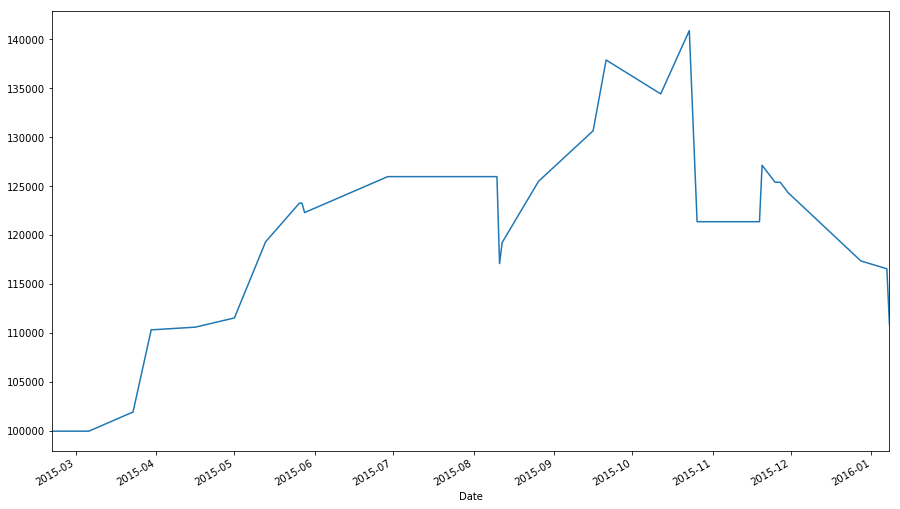

In [35]:
bk = backtest(signals, 100000)
bk
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()
x=bk["Portfolio Value"].groupby(level=0).apply(lambda x:x[-1])
print ((x[-1]-100000)/100000)


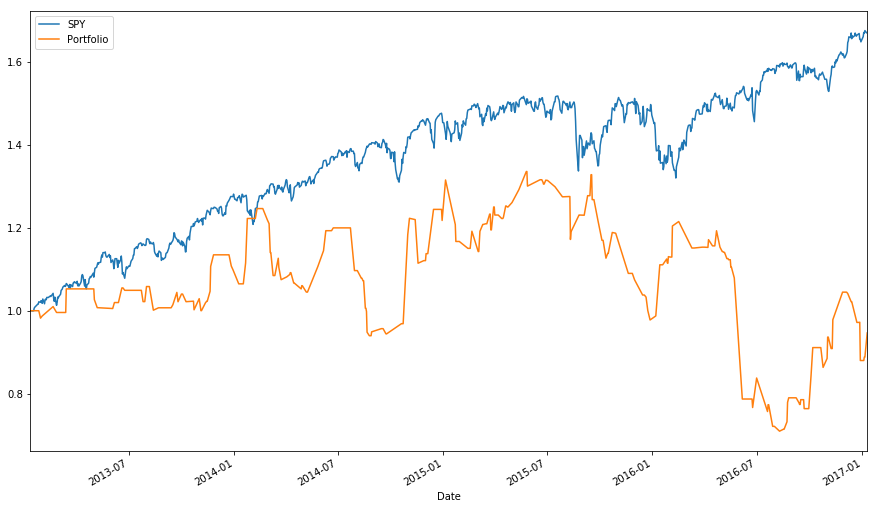

In [13]:
spyder = web.DataReader("SPY", "yahoo", start, end)
ax_bench = (spyder["Adj Close"] / spyder.ix[0, "Adj Close"]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 100000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench

In [ ]:
def bolinger(name):
    name['ave'] =  name["Adj Close"].rolling(window=10, center = False).mean()
    sd =  name["Adj Close"].rolling(window=10, center = False).std()
    name['upper'] = name['ave'] + (sd*2)
    name['lower'] = name['ave'] - (sd*2)
    pandas_candlestick_ohlc(name.loc['2016-01-04':'2017-02-01',:], otherseries = ["ave","upper","lower"])
    
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

    
bolinger(stkname)

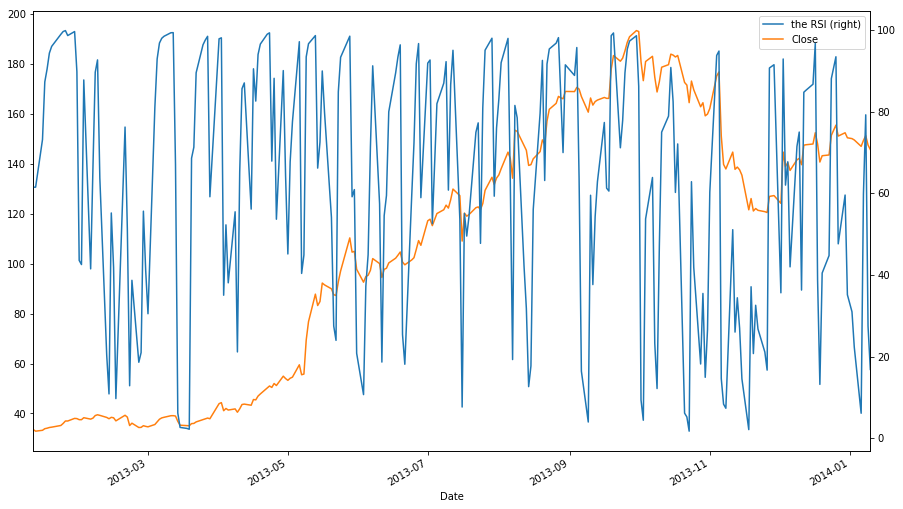

In [21]:
tesla["the RSI"]=rsiFunc(tesla["Close"])
tesla["the RSI"].plot(secondary_y=True, legend=True)
tesla["Close"].plot(legend=True)
fast=12
slow=37
fast_str = str(fast) + 'd'
slow_str = str(slow) + 'd'

        
#tesla[fast_str] = tesla["Close"].rolling(window = fast, center = False).mean()
#tesla[slow_str] = tesla["Close"].rolling(window = slow, center = False).mean() 


#tesla[fast_str].plot(legend=True)
#tesla[slow_str].plot(legend=True)


In [101]:
test=[0]*10
for x in test:
    y=x
    x=y+1
   
    print (x)

1
1
1
1
1
1
1
1
1
1


In [14]:
import pandas as pd
import numpy as np
import urllib
import datetime as dt
import matplotlib.pyplot as plt
 
def get_google_data(symbol, period, window):
    url_root = 'http://www.google.com/finance/getprices?i='
    url_root += str(period) + '&amp;amp;p=' + str(window)
    url_root += 'd&amp;amp;f=d,o,h,l,c,v&amp;amp;df=cpct&amp;amp;q=' + symbol
    response = urllib.request.urlopen(url_root)
    data = response.read().split(b'\n')
    #actual data starts at index = 7
    #first line contains full timestamp,
    #every other line is offset of period from timestamp
    parsed_data = []
    anchor_stamp = ''
    end = len(data)
    for i in range(7, end):
        cdata = data[i].split(',')
        if 'a' in cdata[0]:
        #first one record anchor timestamp
            anchor_stamp = cdata[0].replace('a', '')
            cts = int(anchor_stamp)
        else:
            try:
                coffset = int(cdata[0])
                cts = int(anchor_stamp) + (coffset * period)
                parsed_data.append((dt.datetime.fromtimestamp(float(cts)), float(cdata[1]), float(cdata[2]), float(cdata[3]), float(cdata[4]), float(cdata[5])))
            except:
                pass # for time zone offsets thrown into data
    df = pd.DataFrame(parsed_data)
    df.columns = ['ts', 'o', 'h', 'l', 'c', 'v']
    df.index = df.ts
    del df['ts']
    return df
spy = get_google_data('SPY', 300, 10)
print (spy)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 6 elements

In [35]:
#importing necessary libraries
import pandas as pd
import numpy as np
import urllib
import datetime as dt
import matplotlib.pyplot as plt

#Starting a function called anomalies_data
def anomalies_data(symbol, period, window):
    url_root = 'http://www.google.com/finance/getprices?i='
    url_root += str(period) + '&p=' + str(window)
    url_root += 'd&f=d,o,h,l,c,v&df=cpct&q=' + symbol
    response = urllib.request.urlopen(url_root)
    data = response.read().split(b'\n')
    #actual data starts at index = 7
    #first line contains full timestamp,
    #every other line is offset of period from timestamp
    parsed_data = []
    anchor_stamp = ''
    end = len(data)
    for i in range(7, end):
        cdata = data[i].split(b',')
        if b'a' in cdata[0]:
            #first one record anchor timestamp
            anchor_stamp = cdata[0].replace(b'a',b'')
            cts = int(anchor_stamp)
        else:
            try:
                coffset = int(cdata[0])
                cts = int(anchor_stamp) + (coffset * period)
                parsed_data.append((dt.datetime.fromtimestamp(float(cts)), float(cdata[1]), float(cdata[2]), float(cdata[3]), float(cdata[4]), float(cdata[5])))
            except:
                pass # for time zone offsets thrown into data
    dataframe = pd.DataFrame(parsed_data)
    dataframe.columns = ['ts', 'Open', 'High', 'Low', 'Close', 'Volume']
    dataframe.index = dataframe.ts
    del dataframe['ts']
    return dataframe

test=anomalies_data("AAPL",60,13)

print (test)

                         Open      High       Low     Close      Volume
ts                                                                     
2017-05-31 09:31:00  154.0150  154.1700  153.9700  154.1100     83617.0
2017-05-31 09:32:00  153.9150  154.0200  153.8500  154.0100     98659.0
2017-05-31 09:33:00  153.9650  154.1157  153.8900  153.9300     81768.0
2017-05-31 09:34:00  153.8500  154.0800  153.8500  153.9680     97154.0
2017-05-31 09:35:00  153.8400  153.8860  153.7100  153.8600    133101.0
2017-05-31 09:36:00  153.8600  153.9400  153.7600  153.8350     56592.0
2017-05-31 09:37:00  153.8700  153.9500  153.8700  153.8700     40611.0
2017-05-31 09:38:00  153.9700  153.9900  153.8600  153.8800     52559.0
2017-05-31 09:39:00  153.9500  154.0000  153.9200  153.9899     49923.0
2017-05-31 09:40:00  153.9600  153.9600  153.9000  153.9400     33124.0
2017-05-31 09:41:00  154.0299  154.0300  153.9300  153.9650     58672.0
2017-05-31 09:42:00  153.9400  154.1000  153.9200  154.0150     